# Mask Detection Demo - Automatic Pipeline (3 / 3)
The following example demonstrates an automatic pipeline for training, evaluating, optimizing and serving the mask detection model using our saved MLRun functions from the previous notebooks.

1. [Setup the Project](#section_1)
2. [Plan Our Pipeline](#section_2)
3. [Write the Workflow](#section_3)
4. [Run the Pipeline](#section_4)

Before we begin, **please select the desired framework** (comment and uncomment the below lines as needed):

In [1]:
framework = "tf-keras"

<a id="section_1"></a>
## 1. Setup the Project

Create a project using `mlrun.get_or_create_project` (ensuring loading it in case it already exists), creating the paths where we'll store the project's artifacts:

In [2]:
import mlrun
import os

# Set our project's name and directory:
project_name = f"{framework}-mask-detection"
project_dir = os.path.abspath("./")

# Create the project:
project = mlrun.get_or_create_project(project_name, project_dir, user_project=True)

> 2021-11-05 12:52:53,043 [info] loaded project tf-keras-mask-detection from MLRun DB


<a id="section_2"></a>
## 2. Plan Our Pipeline

Our pipeline will follow the strecture below:

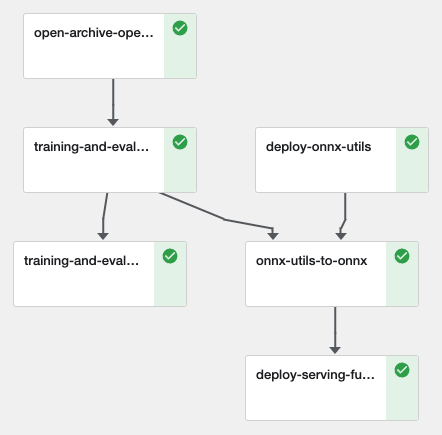


### 2.1. Get the Training, Evaluation and Serving Functions
We wish to use our training, evaluation and serving functions from the previous notebooks. In order to get them, we will set them into the project using `project.set_function`:

In [3]:
# Get our train/evaluation function like in the first notebook:
project.set_function(
    os.path.join(framework, "training-and-evaluation.py"),
    name="training-and-evaluation",
    kind="job",
    image="mlrun/ml-models",
)

# Get our serving function like in the second notebook:
project.set_function(
    os.path.join(framework, "serving.py"),
    name="serving-function", 
    kind="serving", 
    image="mlrun/ml-models",
)

### 2.2. Get the Open Archive and ONNX Functions

We will import the following Marketplace MLRun functions to our project:
* `open_archive` - Download the images dataset as seen in the first notebook.
* `onnx_utils` - ONNX intigration in MLRun, some utils functions for the ONNX framework, optimizing and converting models from different framework to ONNX using MLRun.

**Notice** we are using the same `project.set_function`.

In [4]:
# Import the `open_archive` function to download the images:
project.set_function("hub://open_archive", name="open_archive")

# Import the `onnx_utils` function to optimize the model:
project.set_function("hub://onnx_utils:development", name="onnx_utils")

<a id="section_3"></a>
## 3. Write the Workflow

In order to follow our plan we will use 3 functions:
* `mlrun.build_function` - Build an image to use in a MLRun function. ONNX requires extra packages so we will prepare its image in advance.
* `mlrun.run_function` - Run a local or remote task as part of a local/kubeflow pipeline. Using this function to run our training and the rest of our functions will insure that if the function is using output from another function, it will run only if the relying function is done.
* `mlrun.deploy_function` - Deploy a real-time (nuclio based) function. Our serving function will be deployed using it.

All of the functions above can receive a function object or just the function name (if it is set using `project.set_function` as we did above). We will access our project's functions when needed using the `project.get_function` method - returns a function object by its name.

**Notice** the serving graph will now serve an ONNX model (not a tf.keras model like before), so we will use `mlrun.frameworks.onnx.ONNXModelServer`.

In [5]:
from kfp import dsl


@dsl.pipeline(name="Mask Detection Pipeline")
def workflow(
    archive_url: str,
    dataset_path: str,
    epochs: int,
    batch_size: int,
    lr: float,
    build_flag: int = 1,
    download_data_flag: int = 1
):
    # Get our project object:
    project = mlrun.get_current_project()
    
    # Write down the ONNX requirements:
    onnx_requirements = [
        "onnx~=1.10.1",
        "onnxruntime~=1.8.1",
        "onnxoptimizer~=0.2.0",
        "onnxmltools~=1.9.0",
        "tf2onnx~=1.9.0"
    ]
    
    ###########################################################
    ###############    Build the ONNX image:    ###############
    ###########################################################
    # Build only if needed:
    with dsl.Condition(build_flag == 1) as build_condition:
        mlrun.build_function(
            function="onnx_utils",
            base_image="mlrun/ml-models",
            requirements=onnx_requirements
        )
    
    ###########################################################
    ###############    Download the dataset:    ###############
    ###########################################################
    # Download only if needed:
    with dsl.Condition(download_data_flag == 1) as download_data_condition:
        # Mount it:
        project.get_function("open_archive").apply(mlrun.mount_v3io())
        # Run it using the 'open_archive' handler:
        open_archive_run = mlrun.run_function(
            function="open_archive",
            handler="open_archive",
            name="download_data",
            inputs={"archive_url": archive_url},
            params={"target_path": dataset_path}
        )
    
    ####################################################
    ###############    Train a model:    ###############
    ####################################################
    # Mount it:
    project.get_function("training-and-evaluation").apply(mlrun.mount_v3io())
    # Run it using our 'train' handler:
    training_run = mlrun.run_function(
        function="training-and-evaluation",
        handler="train",
        name="training",
        params={
            "dataset_path": dataset_path,
            "batch_size": batch_size,
            "lr": lr,
            "epochs": epochs
        },
        outputs=["mask_detector"]
    ).after(download_data_condition)
    
    ###################################################################
    ###############    Convert to ONNX and optimize:    ###############
    ###################################################################
    # Mount it:
    project.get_function("onnx_utils").apply(mlrun.mount_v3io())
    # Run it using the 'to_onnx' handler:
    to_onnx_run = mlrun.run_function(
        function="onnx_utils",
        handler="to_onnx",
        name="optimizing",
        params={
            "model_name": 'mask_detector',
            "model_path": training_run.outputs['mask_detector'],
        },
        outputs=["onnx_mask_detector"],
    ).after(build_condition)
    
    #########################################################
    ###############    Evaluate the model:    ###############
    #########################################################
    # Run it using our 'evaluate' handler:
    evaluation_run = mlrun.run_function(
        function="training-and-evaluation",
        handler="evaluate",
        name="evaluating",
        params={
            "model_path": training_run.outputs['mask_detector'],
            "dataset_path": dataset_path,
            "batch_size": batch_size
        }
    )
    
    ################################################################################
    ###############    Deploy the model as a serverless function:    ###############
    ################################################################################
    # Get the function:
    serving_function = project.get_function("serving-function")
    # Mount it:
    serving_function.apply(mlrun.mount_v3io())
    # Set the topology and get the graph object:
    graph = serving_function.set_topology("flow", engine="async")
    # Build the serving graph:
    graph.to(handler="resize", name="resize")\
         .to(handler="preprocess", name="preprocess")\
         .to("mlrun.frameworks.onnx.ONNXModelServer", "onnx_mask_detector", model_path=project.get_artifact_uri("onnx_mask_detector"))\
         .to(handler="postprocess", name="postprocess").respond()
    # Set the desired requirements:
    serving_function.with_requirements(requirements=onnx_requirements)
    # Deploy the serving function:
    mlrun.deploy_function("serving-function").after(to_onnx_run)

<a id="section_4"></a>
## 4. Run the Pipeline:

We will run the pipeline using `project.run` with the workflow we just wrote:

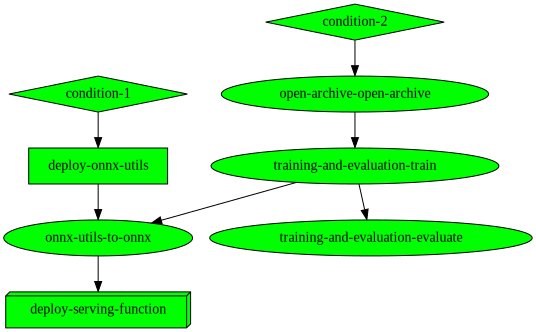

uid,start,state,name,results,artifacts
...03fd98b5,Nov 05 12:55:49,completed,onnx-utils-to_onnx,,onnx_mask_detector.onnxonnx_mask_detector
...bc28fc9e,Nov 05 12:55:39,completed,training-and-evaluation-evaluate,model_path=store://artifacts/tf-keras-mask-detection-guyl/mask_detector:2e8f8c40-eaac-4544-9e8f-e358c5d490fbdataset_path=/User/demos/mask-detection/tf-keras/Datasetbatch_size=32evaluation_loss=0.007536282373029132evaluation_accuracy=0.997093023255814,evaluation_loss_epoch_1.htmlevaluation_accuracy_epoch_1.html
...0fdc1175,Nov 05 12:53:46,completed,training-and-evaluation-train,dataset_path=/User/demos/mask-detection/tf-keras/Datasetbatch_size=32epochs=3lr=0.0010000000474974513training_loss=0.0011849403381347656training_accuracy=1.0001335144042969validation_loss=0.007276227904690636validation_accuracy=1.0,training_loss_epoch_1.htmltraining_accuracy_epoch_1.htmlvalidation_loss_epoch_1.htmlvalidation_accuracy_epoch_1.htmltraining_loss_epoch_2.htmltraining_accuracy_epoch_2.htmlvalidation_loss_epoch_2.htmlvalidation_accuracy_epoch_2.htmltraining_loss_epoch_3.htmltraining_accuracy_epoch_3.htmlvalidation_loss_epoch_3.htmlvalidation_accuracy_epoch_3.htmlloss_summary.htmlaccuracy_summary.htmllr.html.htmlmask_detector.zipmask_detector
...182d545e,Nov 05 12:53:22,completed,open-archive-open_archive,,content


2e8f8c40-eaac-4544-9e8f-e358c5d490fb

In [6]:
project.run(
    name="mask-detection-pipeline",
    workflow_handler=workflow,
    arguments={
        "archive_url": f"{mlrun.mlconf.default_samples_path}data/prajnasb-generated-mask-detection/prajnasb_generated_mask_detection.zip",
        "dataset_path": os.path.abspath('./Dataset'),
        "epochs": 3,
        "batch_size": 32, 
        "lr": 1e-3,
        "build_flag": 1,
        "download_data_flag": 1
    },
    watch=True
)